# **Licenciatura em Ciências da Computação**

### Aprendizagem Computacional 25/26

In [ ]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.datasets import make_blobs

# Configuration
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_rows', 8)
np.random.seed(42)

print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {__import__('sklearn').__version__}")

NumPy: 2.0.2
Pandas: 2.2.2
Scikit-learn: 1.6.1


In [ ]:
# Create a synthetic chemical compounds dataset
np.random.seed(42)

# Simulate chemical compound properties
n_compounds = 150

# Generate compound data with 3 natural groups
# Group 1: Small organic molecules (low MW, high solubility)
# Group 2: Medium polymers (medium MW, medium solubility)
# Group 3: Large proteins (high MW, low solubility)

compounds_data = []
labels_true = []

# Group 1: Small molecules
for i in range(50):
    mw = np.random.normal(150, 30)  # Molecular weight  #mean, std
    solubility = np.random.normal(8, 1.5)  # Log solubility
    melting_point = np.random.normal(80, 20)
    compounds_data.append([mw, solubility, melting_point])
    labels_true.append(0)

# Group 2: Medium molecules
for i in range(50):
    mw = np.random.normal(500, 100)
    solubility = np.random.normal(4, 1)
    melting_point = np.random.normal(180, 30)
    compounds_data.append([mw, solubility, melting_point])
    labels_true.append(1)

# Group 3: Large molecules
for i in range(50):
    mw = np.random.normal(1200, 200)
    solubility = np.random.normal(1, 0.8)
    melting_point = np.random.normal(280, 40)
    compounds_data.append([mw, solubility, melting_point])
    labels_true.append(2)

# Create DataFrame
compounds_df = pd.DataFrame(
    compounds_data,
    columns=['molecular_weight', 'log_solubility', 'melting_point']
)

# Add compound names
compound_names = [f"Compound_{i+1:03d}" for i in range(n_compounds)]
compounds_df['compound_name'] = compound_names

print("Chemical Compounds Dataset:")
print(compounds_df.head())
print(f"\nDataset shape: {compounds_df.shape}")

Chemical Compounds Dataset:
   molecular_weight  log_solubility  melting_point compound_name
0        164.901425        7.792604      92.953771  Compound_001
1        195.690896        7.648770      75.317261  Compound_002
2        197.376384        9.151152      70.610512  Compound_003
3        166.276801        7.304873      70.685405  Compound_004
4        157.258868        5.130080      45.501643  Compound_005

Dataset shape: (150, 4)


In [ ]:
# Prepare features for clustering (exclude compound names)
features = compounds_df[['molecular_weight', 'log_solubility', 'melting_point']]

print("Before scaling:")
print(features.describe())

# Scale the features (mean=0, std=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert back to DataFrame for easier handling
features_scaled_df = pd.DataFrame(
    features_scaled,
    columns=['molecular_weight_scaled', 'log_solubility_scaled', 'melting_point_scaled']
)

print("\nAfter scaling:")
print(features_scaled_df.describe())

print("\nWhy scaling? All features now have mean≈0 and std≈1, so no single feature dominates!")

Before scaling:
       molecular_weight  log_solubility  melting_point
count        150.000000      150.000000     150.000000
mean         626.110300        4.191975     183.578467
std          456.950150        3.032383      90.354507
min          107.944468       -0.699117      27.605098
25%          160.852768        1.557595      90.757393
50%          527.884133        3.710037     190.484090
75%         1046.247376        6.817986     263.462731
max         1637.960587       10.829279     366.127298

After scaling:
       molecular_weight_scaled  log_solubility_scaled  melting_point_scaled
count             1.500000e+02           1.500000e+02          1.500000e+02
mean             -1.421085e-16          -1.421085e-16          9.473903e-17
std               1.003350e+00           1.003350e+00          1.003350e+00
min              -1.137765e+00          -1.618356e+00         -1.732021e+00
25%              -1.021591e+00          -8.716595e-01         -1.030740e+00
50%              

### Mini‑exercises (Data Exploration) — ~8 min
1. Calculate the correlation matrix between the three numerical variables.  
2. Create a histogram for each of the three properties.  
3. Which two variables seem most strongly correlated?

Correlation matrix:
                  molecular_weight  log_solubility  melting_point
molecular_weight          1.000000       -0.851626       0.885128
log_solubility           -0.851626        1.000000      -0.877404
melting_point             0.885128       -0.877404       1.000000 



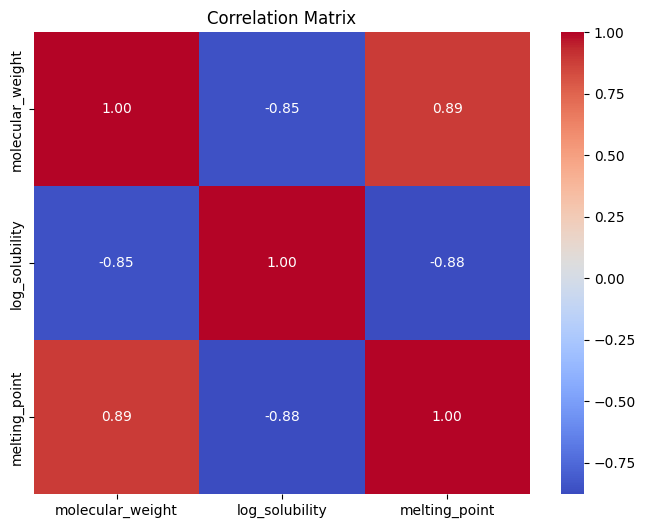

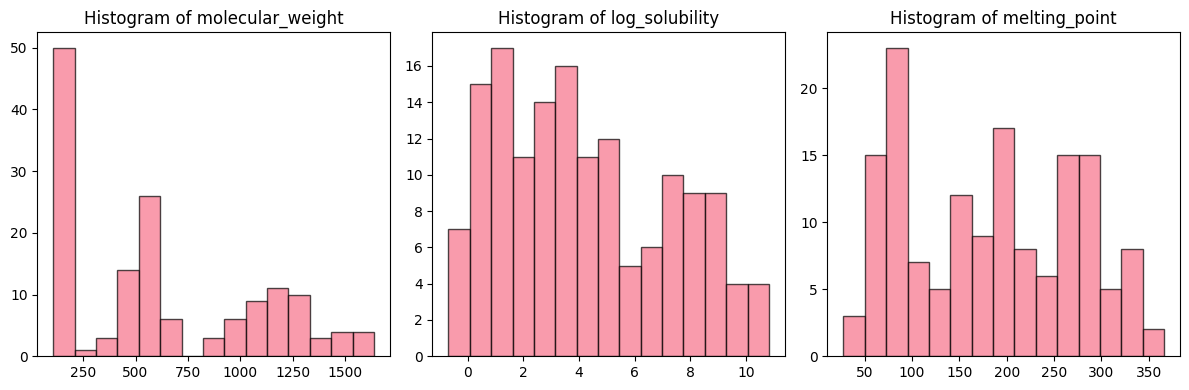

Most strongly correlated pair: ('molecular_weight', 'melting_point') with correlation 0.89


In [ ]:
# === SOLUTION: Mini‑exercises (Data Exploration) ===

numeric_cols = ["molecular_weight","log_solubility","melting_point"]

# 1. Correlation matrix
corr_matrix = compounds_df[numeric_cols].corr()
print("Correlation matrix:")
print(corr_matrix, "\n")

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# 2. Histograms for each property
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, col in zip(axes, numeric_cols):
    ax.hist(compounds_df[col], bins=15, alpha=0.7, edgecolor="black")
    ax.set_title(f"Histogram of {col}")

plt.tight_layout()
plt.show()

### Mini‑exercises (Hierarchical Clustering) — ~15 min

Hierarchical clustering, specifically **Agglomerative Clustering**, is another unsupervised learning technique that builds a hierarchy of clusters. Unlike K-Means, you don't need to specify the number of clusters beforehand, although you often need to decide where to cut the hierarchy to form clusters.

Here's how to import and use it:

1. **Apply Agglomerative Clustering:** Use `AgglomerativeClustering` from `sklearn.cluster`. Apply it to the `features_scaled` data, setting `n_clusters` to 3 to compare with the K-Means results.
2. **Compare Silhouette Scores:** Calculate and print the silhouette score for the Agglomerative Clustering results and compare it to the K-Means silhouette score you calculated earlier. What do you observe?
3. **Visualize Results:** Create a scatter plot showing the Molecular Weight (scaled) versus Log Solubility (scaled), coloring the points based on the cluster labels from the Agglomerative Clustering. How does this visualization compare to the K-Means visualization of the same features?

Agglomerative Clustering Silhouette Score (n_clusters=3): 0.633
K-Means Clustering Silhouette Score (k=3): 0.633


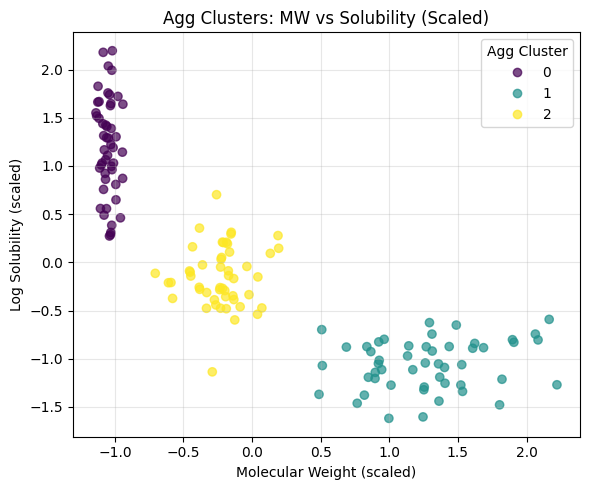

In [ ]:
# Space for Hierarchical Clustering exercises
# Exercise 1: Apply Agglomerative Clustering and compare silhouette scores
agg_clustering_compounds = AgglomerativeClustering(n_clusters=3)
cluster_labels_agg_compounds = agg_clustering_compounds.fit_predict(features_scaled)

silhouette_agg = silhouette_score(features_scaled, cluster_labels_agg_compounds)
print(f"Agglomerative Clustering Silhouette Score (n_clusters=3): {silhouette_agg:.3f}")

# Perform K-Means clustering to get cluster labels for comparison
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_scaled)
print(f"K-Means Clustering Silhouette Score (k=3): {silhouette_score(features_scaled, kmeans_labels):.3f}")

plt.figure(figsize=(6, 5))

scatter = plt.scatter(
    features_scaled[:, 0],
    features_scaled[:, 1],
    c=cluster_labels_agg_compounds,   # cluster IDs
    cmap='viridis',                   # or 'tab10', 'Set1', etc.
    alpha=0.7
)

plt.xlabel('Molecular Weight (scaled)')
plt.ylabel('Log Solubility (scaled)')
plt.title('Agg Clusters: MW vs Solubility (Scaled)')

plt.legend(*scatter.legend_elements(), title="Agg Cluster")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In this case, both Agglomerative Clustering and K-Means Clustering achieved a Silhouette Score of approximately 0.633. This means that, for this particular dataset and with 3 clusters, both algorithms resulted in clusters of similar quality. The score of 0.633 suggests that the clusters are reasonably well-separated and the data points are relatively well-assigned to their respective clusters.



PCA Results:
PC1: 0.914 (91.4%) - Cumulative: 0.914 (91.4%)
PC2: 0.050 (5.0%) - Cumulative: 0.964 (96.4%)
PC3: 0.036 (3.6%) - Cumulative: 1.000 (100.0%)


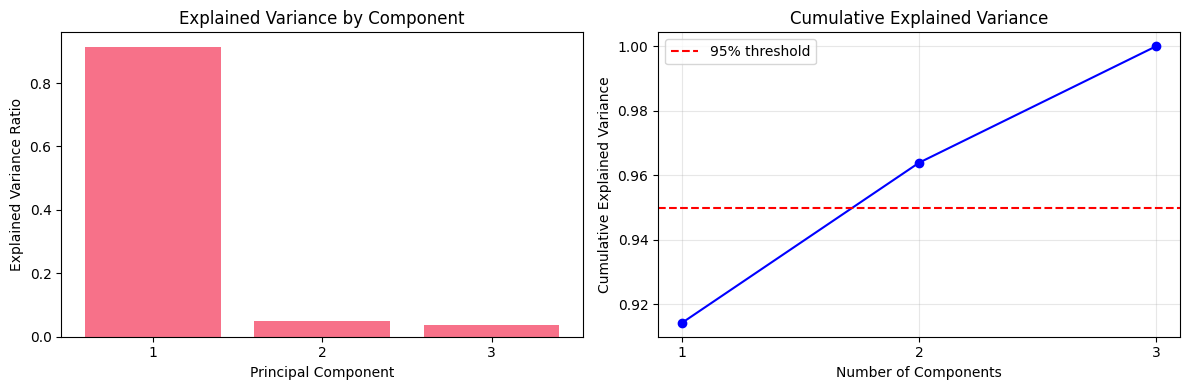

In [ ]:

# Apply PCA to our chemical compounds data
pca = PCA()
pca_features = pca.fit_transform(features_scaled)

# Check explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("PCA Results:")
print("=" * 30)
for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1}: {ev:.3f} ({ev*100:.1f}%) - Cumulative: {cv:.3f} ({cv*100:.1f}%)")

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Individual variance
ax1.bar(range(1, len(explained_variance)+1), explained_variance)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Explained Variance by Component')
ax1.set_xticks(range(1, len(explained_variance)+1))

# Cumulative variance
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'bo-')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.set_xticks(range(1, len(cumulative_variance)+1))
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

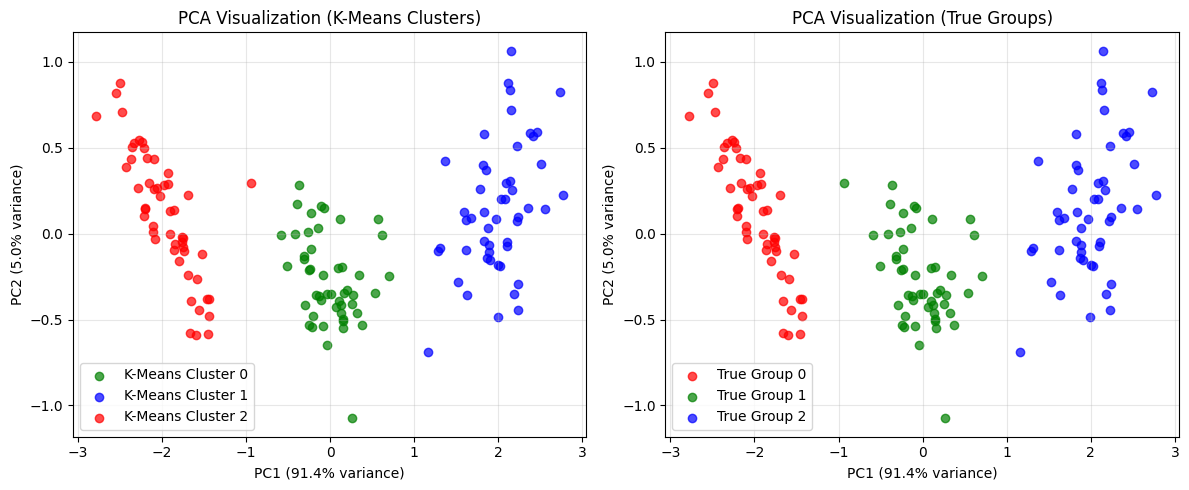


First 2 PCs capture 96.4% of the total variance!


In [ ]:
# Visualize data in PCA space (2D)
# Define colors for true groups (Small, Medium, Large)
true_group_colors = ['red', 'green', 'blue']

# Map K-Means cluster labels to match the true group colors for visual consistency
# Based on observation:
# K-Means Cluster 2 corresponds to True Group 0 (Small Molecules - Red)
# K-Means Cluster 0 corresponds to True Group 1 (Medium Molecules - Green)
# K-Means Cluster 1 corresponds to True Group 2 (Large Molecules - Blue)
kmeans_cluster_colors = ['green', 'blue', 'red'] # Colors for K-Means clusters 0, 1, 2 respectively

# Add K-Means cluster labels to compounds_df
compounds_df['cluster'] = kmeans_labels

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# PCA visualization colored by K-Means clusters
for i in range(3):
    cluster_data = compounds_df[compounds_df['cluster'] == i]
    cluster_indices = cluster_data.index
    ax1.scatter(pca_features[cluster_indices, 0], pca_features[cluster_indices, 1],
               c=kmeans_cluster_colors[i], label=f'K-Means Cluster {i}', alpha=0.7)
ax1.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)')
ax1.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)')
ax1.set_title('PCA Visualization (K-Means Clusters)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PCA visualization colored by true groups
for i in range(3):
    true_group_indices = np.array([j for j in range(len(labels_true)) if labels_true[j] == i])
    ax2.scatter(pca_features[true_group_indices, 0], pca_features[true_group_indices, 1],
               c=true_group_colors[i], label=f'True Group {i}', alpha=0.7)
ax2.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)')
ax2.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)')
ax2.set_title('PCA Visualization (True Groups)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFirst 2 PCs capture {cumulative_variance[1]*100:.1f}% of the total variance!")

### Mini‑exercises (PCA) — ~10 min
1. How many principal components do we need to capture 95% of the variance?
2. Create a new compound with properties [MW=300, log_sol=5, MP=150] and project it into PCA space.

In [ ]:
# Space for PCA exercises

# Exercise 1: How many principal components do we need to capture 95% of the variance?
# We already calculated cumulative_variance in the previous cell.
# Find the first number of components where cumulative_variance is >= 0.95
n_components_95_var = (cumulative_variance >= 0.95).argmax() + 1

print(f"Number of components to capture 95% variance: {n_components_95_var}")


# Exercise 2: Create a new compound with properties [MW=300, log_sol=5, MP=150] and project it into PCA space.
new_compound_properties = pd.DataFrame(
    [[300, 5, 150]],
    columns=['molecular_weight', 'log_solubility', 'melting_point']
)


# We need to scale the new compound properties using the same scaler fitted on the original data
new_compound_scaled = scaler.transform(new_compound_properties)

# Project the scaled new compound into PCA space using the fitted PCA model
new_compound_pca = pca.transform(new_compound_scaled)

print(f"\nScaled properties of the new compound: {new_compound_scaled}")
print(f"New compound projected into PCA space (PC1, PC2, PC3): {new_compound_pca}")